In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
def collect_data(dir):
    import os, json
    trials = []
    for root, _, files in os.walk(dir):
        if "params.json" in files and "results.npz" in files:
            with open(os.path.join(root, "params.json")) as f:
                params = json.load(f)
            data = np.load(os.path.join(root, "results.npz"), allow_pickle=True)
            results = {}
            for k, v in data.items():
                v = np.asarray(v)
                # Treat singleton arrays as scalars
                if v.size == 1:
                    v = float(v)
                results[k] = v
            trials.append((params, results))
    return trials

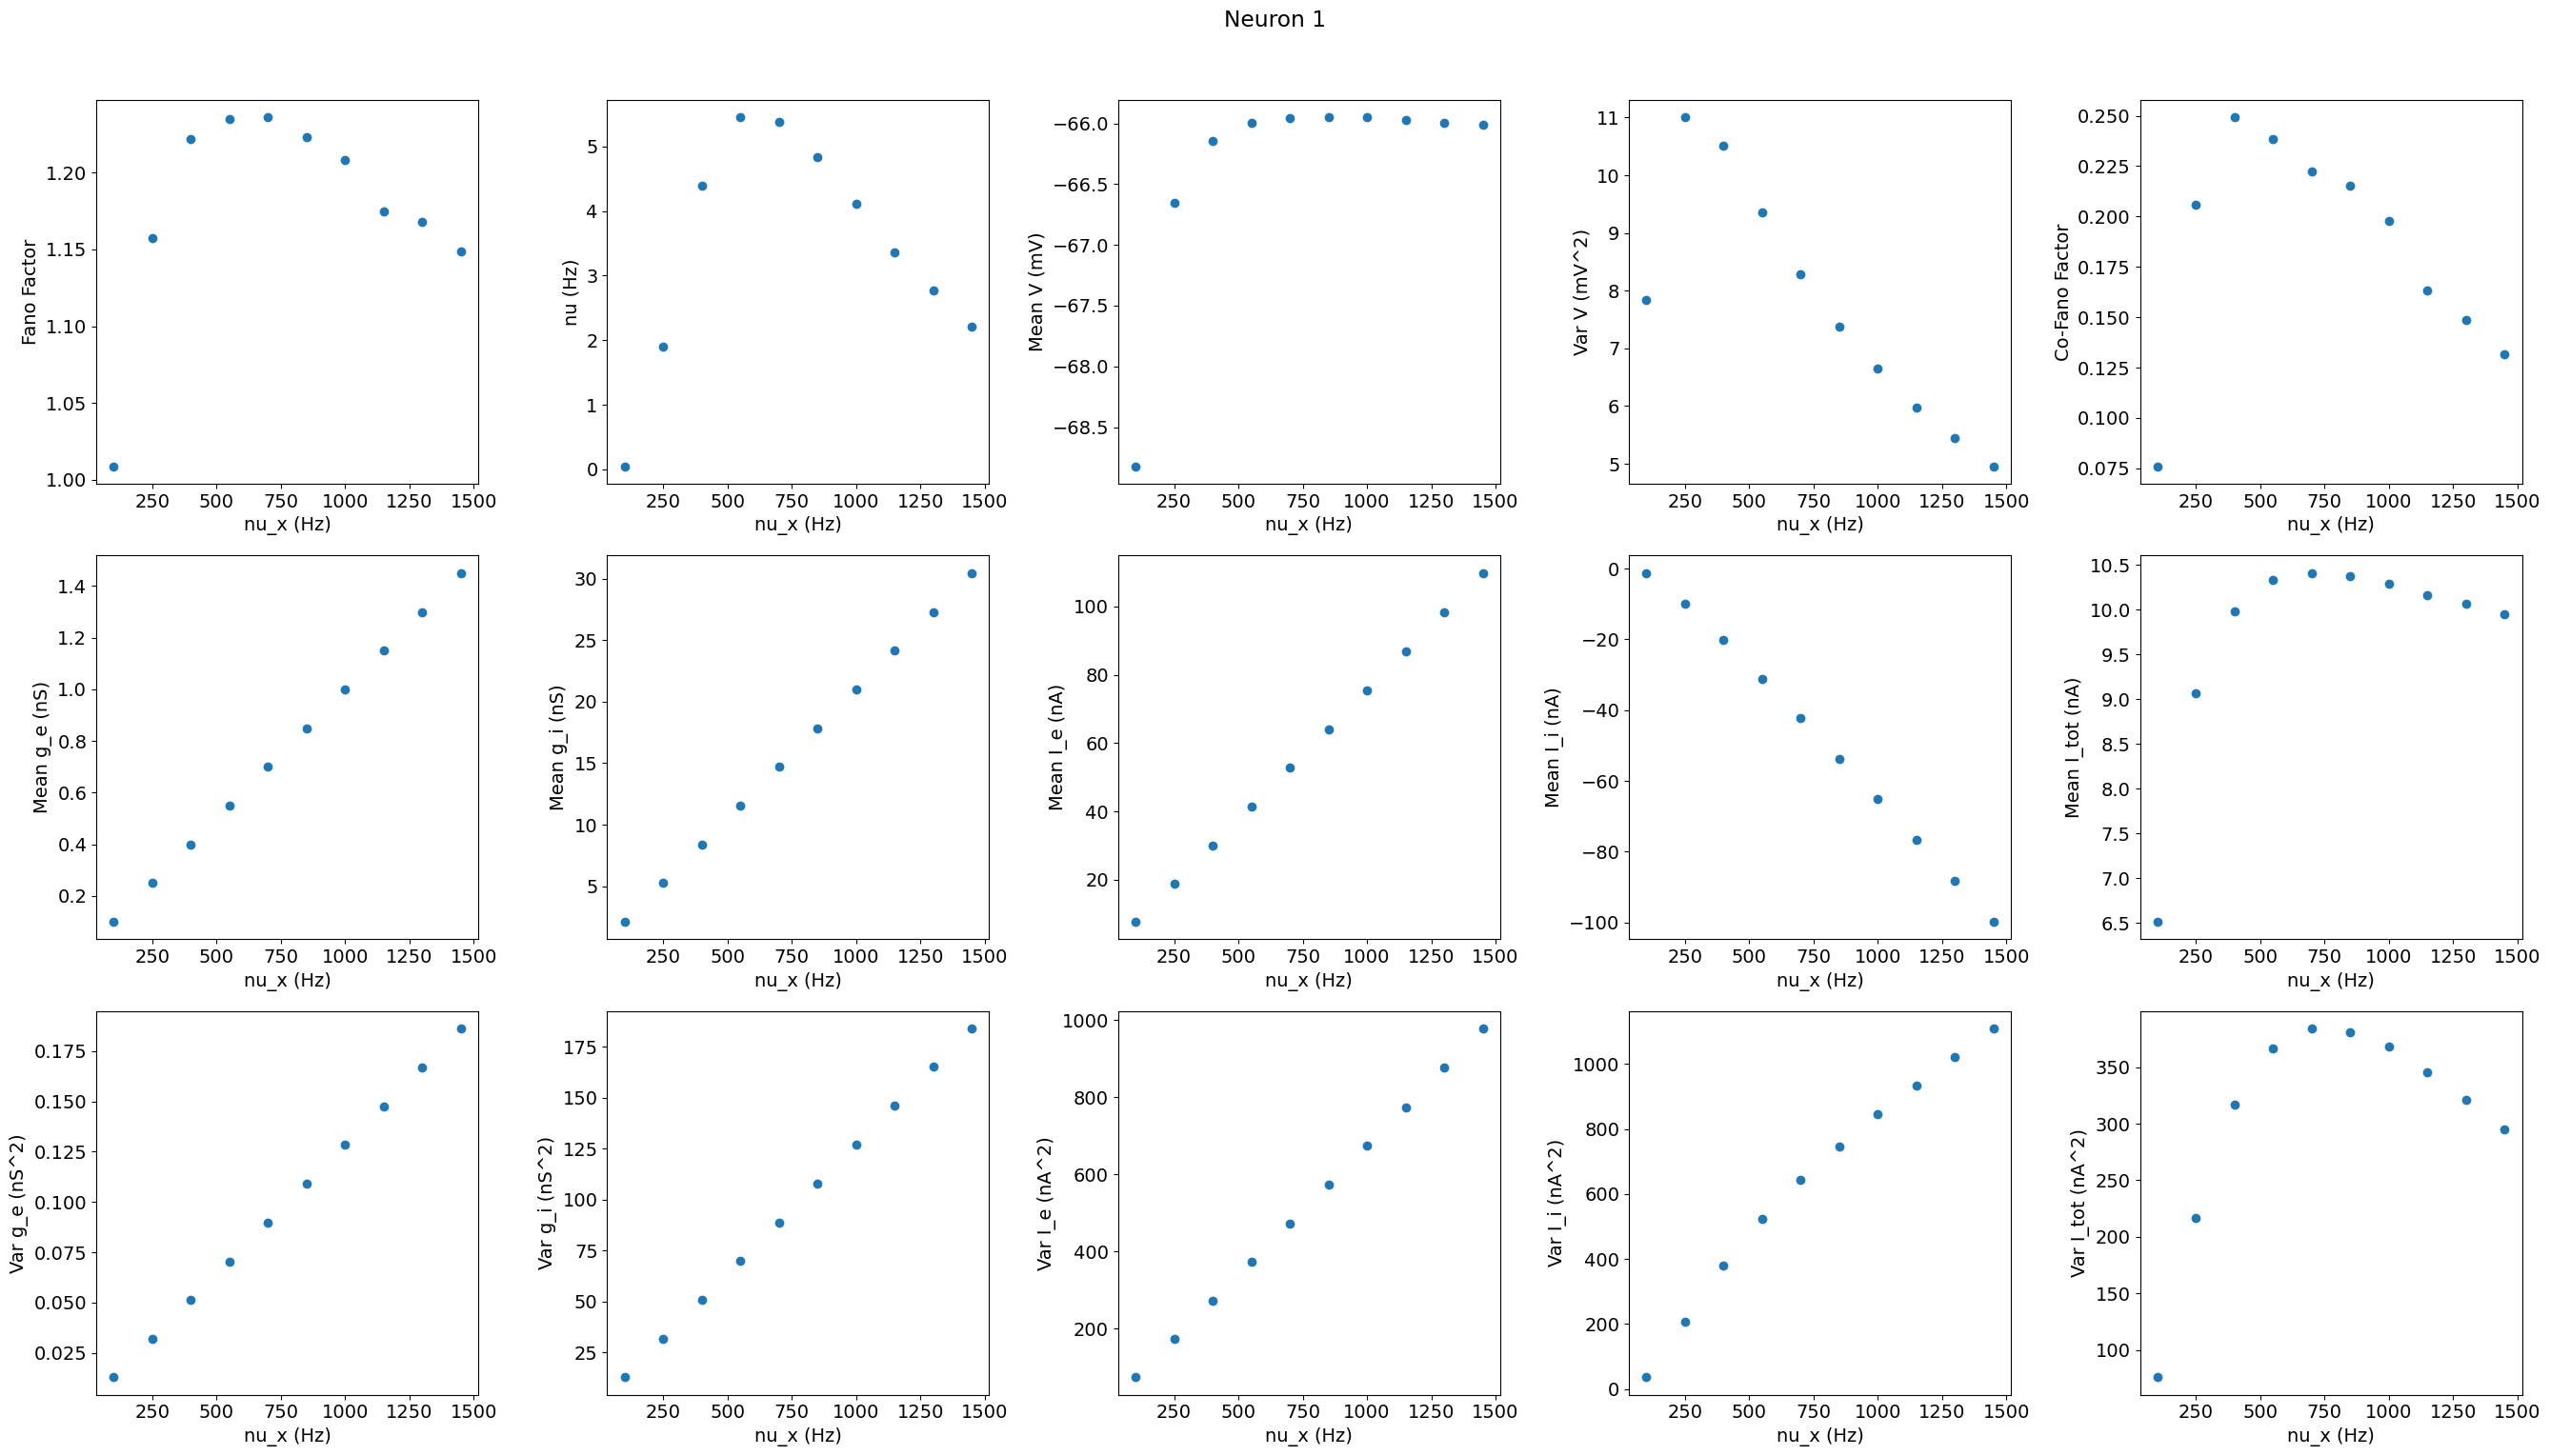

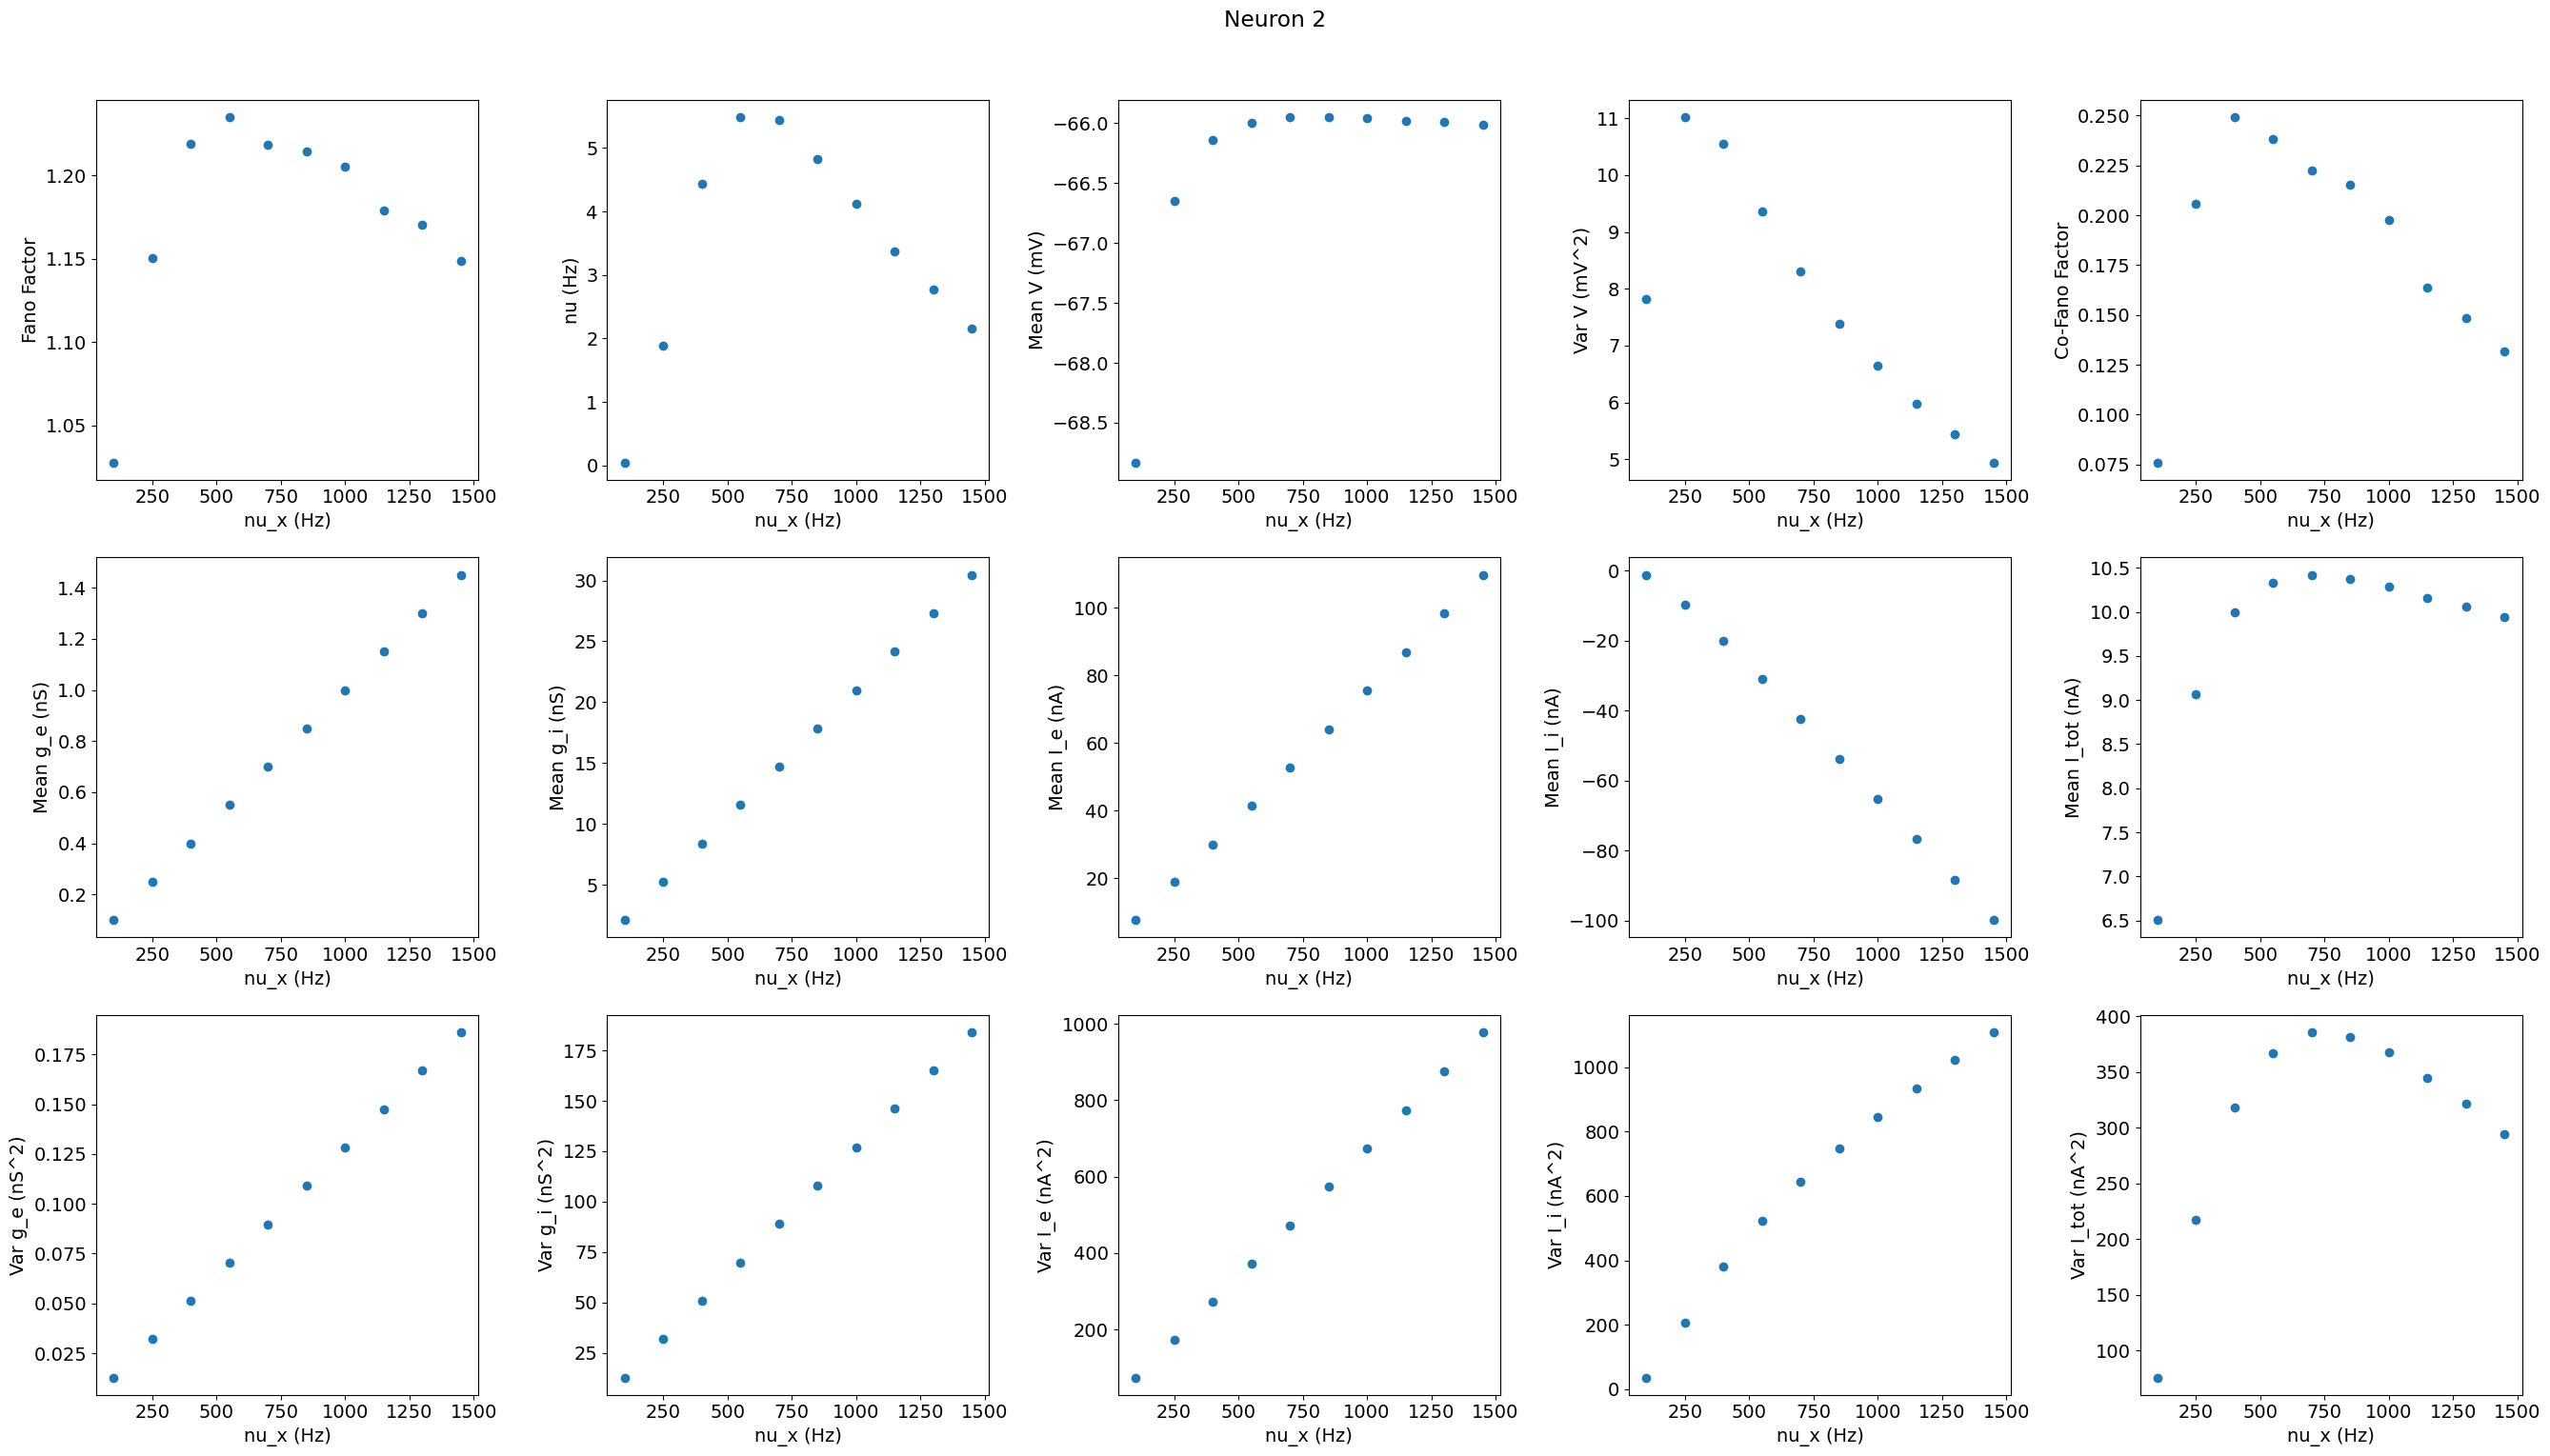

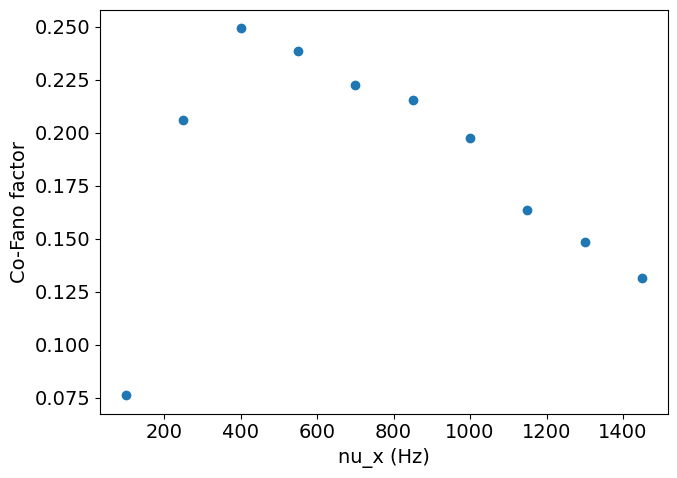

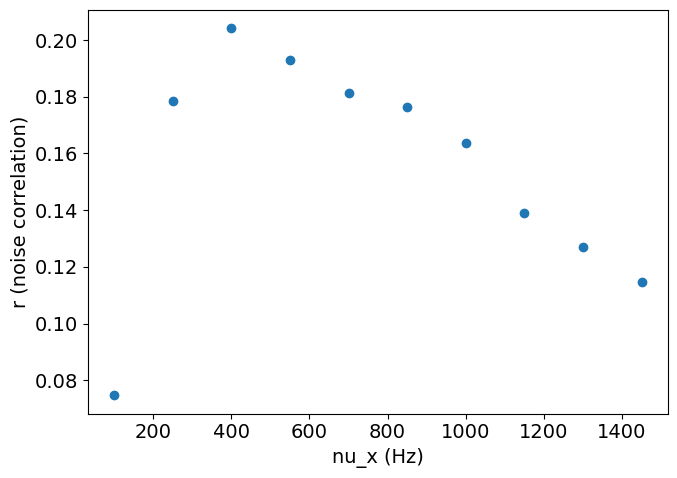

In [44]:
trials = collect_data("../../outputs/conductance/double_lif/nu_x_1/20251016-004114-dZgtdphQ")


plt.rcParams.update({'font.size': 14})

keys = [
    "fano_factor","nu","mean_V","var_V",
    "mean_g_e","mean_g_i","mean_I_e","mean_I_i","mean_I_tot",
    "var_g_e","var_g_i","var_I_e","var_I_i","var_I_tot",
]

N_CELLS = 2

dfs = []
for i in range(N_CELLS):
    rows = []
    for params, results in trials:
        row = {"nu_x": float(params["nu_x"])}
        for k in keys:
            v = results[k]
            if np.isscalar(v) or (isinstance(v, np.ndarray) and v.ndim == 0):
                row[k] = float(v)
            elif isinstance(v, np.ndarray) and v.ndim == 1 and v.size == N_CELLS:
                row[k] = float(v[i])
            # ignore everything else (e.g., 2D buffers or mismatched shapes)
        rows.append(row)
    dfs.append(pd.DataFrame(rows))

df_co = pd.DataFrame(
    {"nu_x": [float(p["nu_x"]) for p, _ in trials],
     "co_fano_factor": [float(np.ravel(r["co_fano_factor"])[0]) for _, r in trials]}
)

def plot_summary(df, neuron_idx, outname):
    fig, axs = plt.subplots(3, 5, figsize=(27, 15))
    fig.suptitle(f"Neuron {neuron_idx+1}", y=1.02)

    axs[0,0].scatter(df["nu_x"], df["fano_factor"]); axs[0,0].set_xlabel("nu_x (Hz)"); axs[0,0].set_ylabel("Fano Factor")
    axs[0,1].scatter(df["nu_x"], df["nu"]);          axs[0,1].set_xlabel("nu_x (Hz)"); axs[0,1].set_ylabel("nu (Hz)")
    axs[0,2].scatter(df["nu_x"], df["mean_V"]);      axs[0,2].set_xlabel("nu_x (Hz)"); axs[0,2].set_ylabel("Mean V (mV)")
    axs[0,3].scatter(df["nu_x"], df["var_V"]);       axs[0,3].set_xlabel("nu_x (Hz)"); axs[0,3].set_ylabel("Var V (mV^2)")
    # do co-fano factor both
    axs[0,4].scatter(df["nu_x"], df_co["co_fano_factor"]); axs[0,4].set_xlabel("nu_x (Hz)"); axs[0,4].set_ylabel("Co-Fano Factor")

    axs[1,0].scatter(df["nu_x"], df["mean_g_e"]);    axs[1,0].set_xlabel("nu_x (Hz)"); axs[1,0].set_ylabel("Mean g_e (nS)")
    axs[1,1].scatter(df["nu_x"], df["mean_g_i"]);    axs[1,1].set_xlabel("nu_x (Hz)"); axs[1,1].set_ylabel("Mean g_i (nS)")
    axs[1,2].scatter(df["nu_x"], df["mean_I_e"]);    axs[1,2].set_xlabel("nu_x (Hz)"); axs[1,2].set_ylabel("Mean I_e (nA)")
    axs[1,3].scatter(df["nu_x"], df["mean_I_i"]);    axs[1,3].set_xlabel("nu_x (Hz)"); axs[1,3].set_ylabel("Mean I_i (nA)")
    axs[1,4].scatter(df["nu_x"], df["mean_I_tot"]);  axs[1,4].set_xlabel("nu_x (Hz)"); axs[1,4].set_ylabel("Mean I_tot (nA)")

    axs[2,0].scatter(df["nu_x"], df["var_g_e"]);     axs[2,0].set_xlabel("nu_x (Hz)"); axs[2,0].set_ylabel("Var g_e (nS^2)")
    axs[2,1].scatter(df["nu_x"], df["var_g_i"]);     axs[2,1].set_xlabel("nu_x (Hz)"); axs[2,1].set_ylabel("Var g_i (nS^2)")
    axs[2,2].scatter(df["nu_x"], df["var_I_e"]);     axs[2,2].set_xlabel("nu_x (Hz)"); axs[2,2].set_ylabel("Var I_e (nA^2)")
    axs[2,3].scatter(df["nu_x"], df["var_I_i"]);     axs[2,3].set_xlabel("nu_x (Hz)"); axs[2,3].set_ylabel("Var I_i (nA^2)")
    axs[2,4].scatter(df["nu_x"], df["var_I_tot"]);   axs[2,4].set_xlabel("nu_x (Hz)"); axs[2,4].set_ylabel("Var I_tot (nA^2)")

    plt.tight_layout(); plt.savefig(outname, dpi=300, bbox_inches="tight"); plt.show()

for i, df in enumerate(dfs):
    plot_summary(df, i, f"detailed_summary_neuron{i+1}.png")

plt.figure(figsize=(7,5))
plt.scatter(df_co["nu_x"], df_co["co_fano_factor"])
plt.xlabel("nu_x (Hz)"); plt.ylabel("Co-Fano factor")
plt.tight_layout(); plt.savefig("co_fano_vs_nu_x.png", dpi=300, bbox_inches="tight"); plt.show()

# noise correlation vs nu_x for various c
plt.figure(figsize=(7,5))
df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])
plt.scatter(df_co["nu_x"], df_co["r"])
plt.xlabel("nu_x (Hz)"); plt.ylabel("r (noise correlation)")
plt.tight_layout(); plt.savefig("r_vs_nu_x.png", dpi=300, bbox_inches="tight"); plt.show()

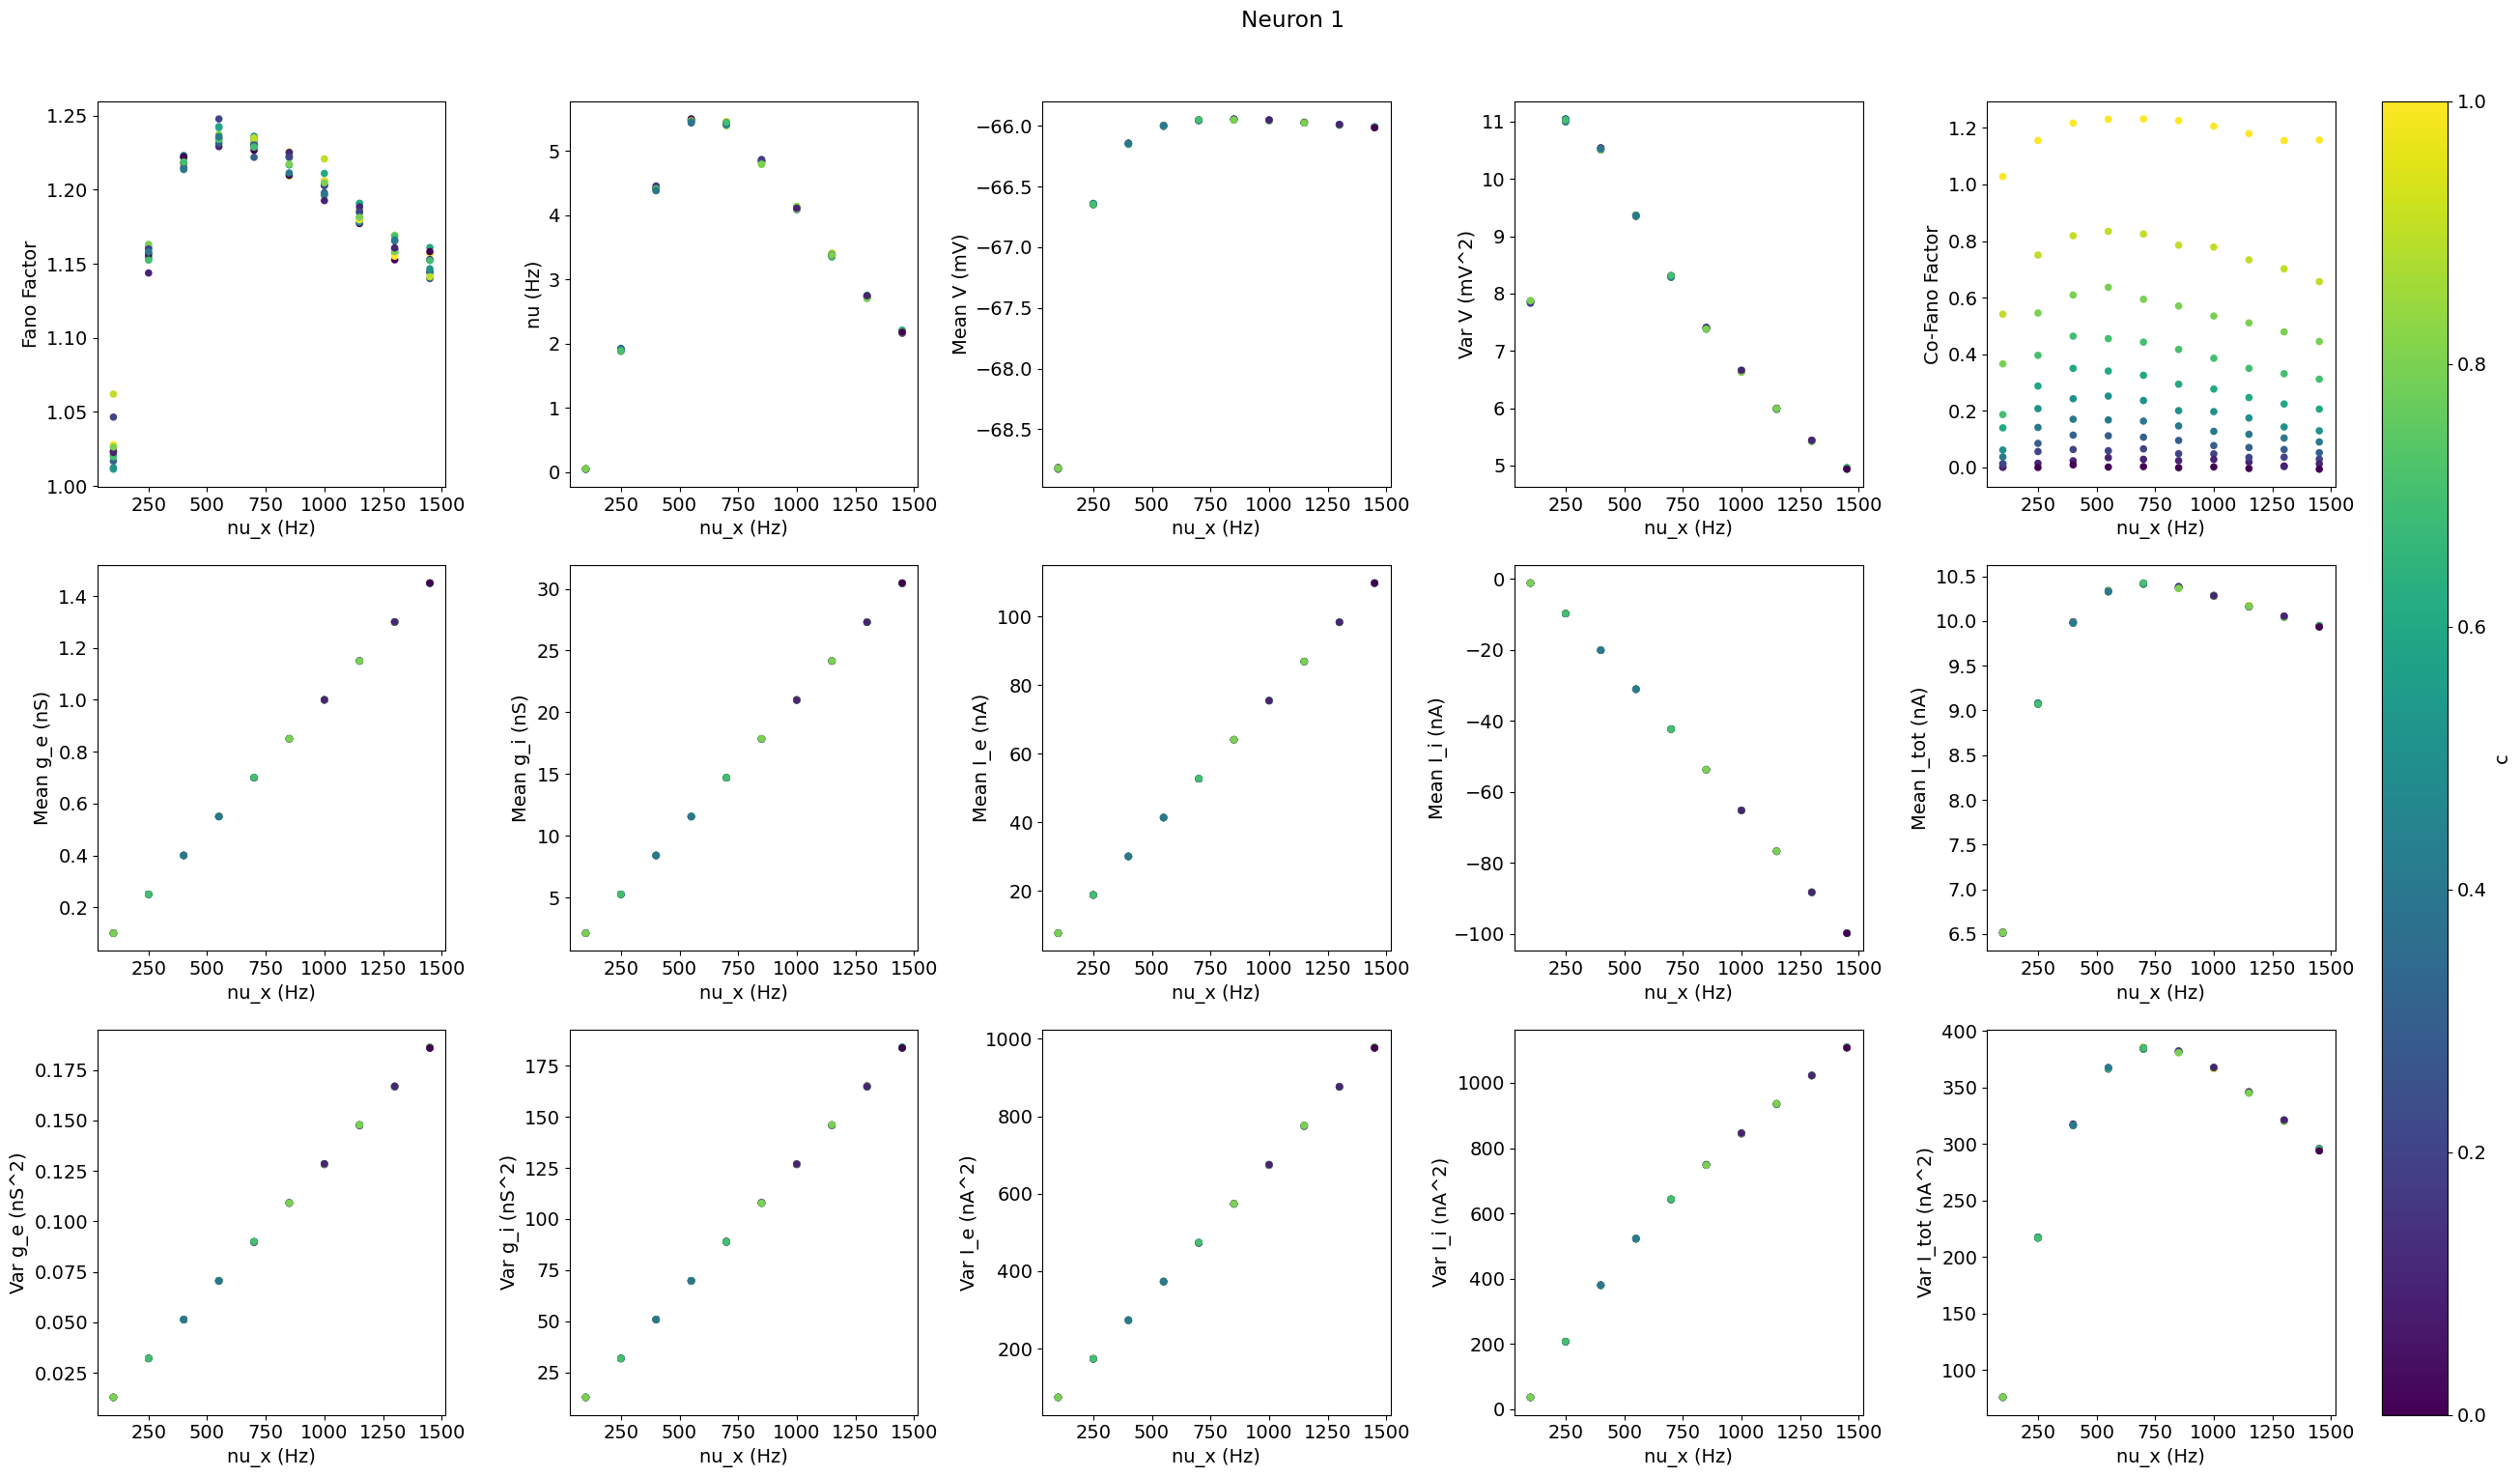

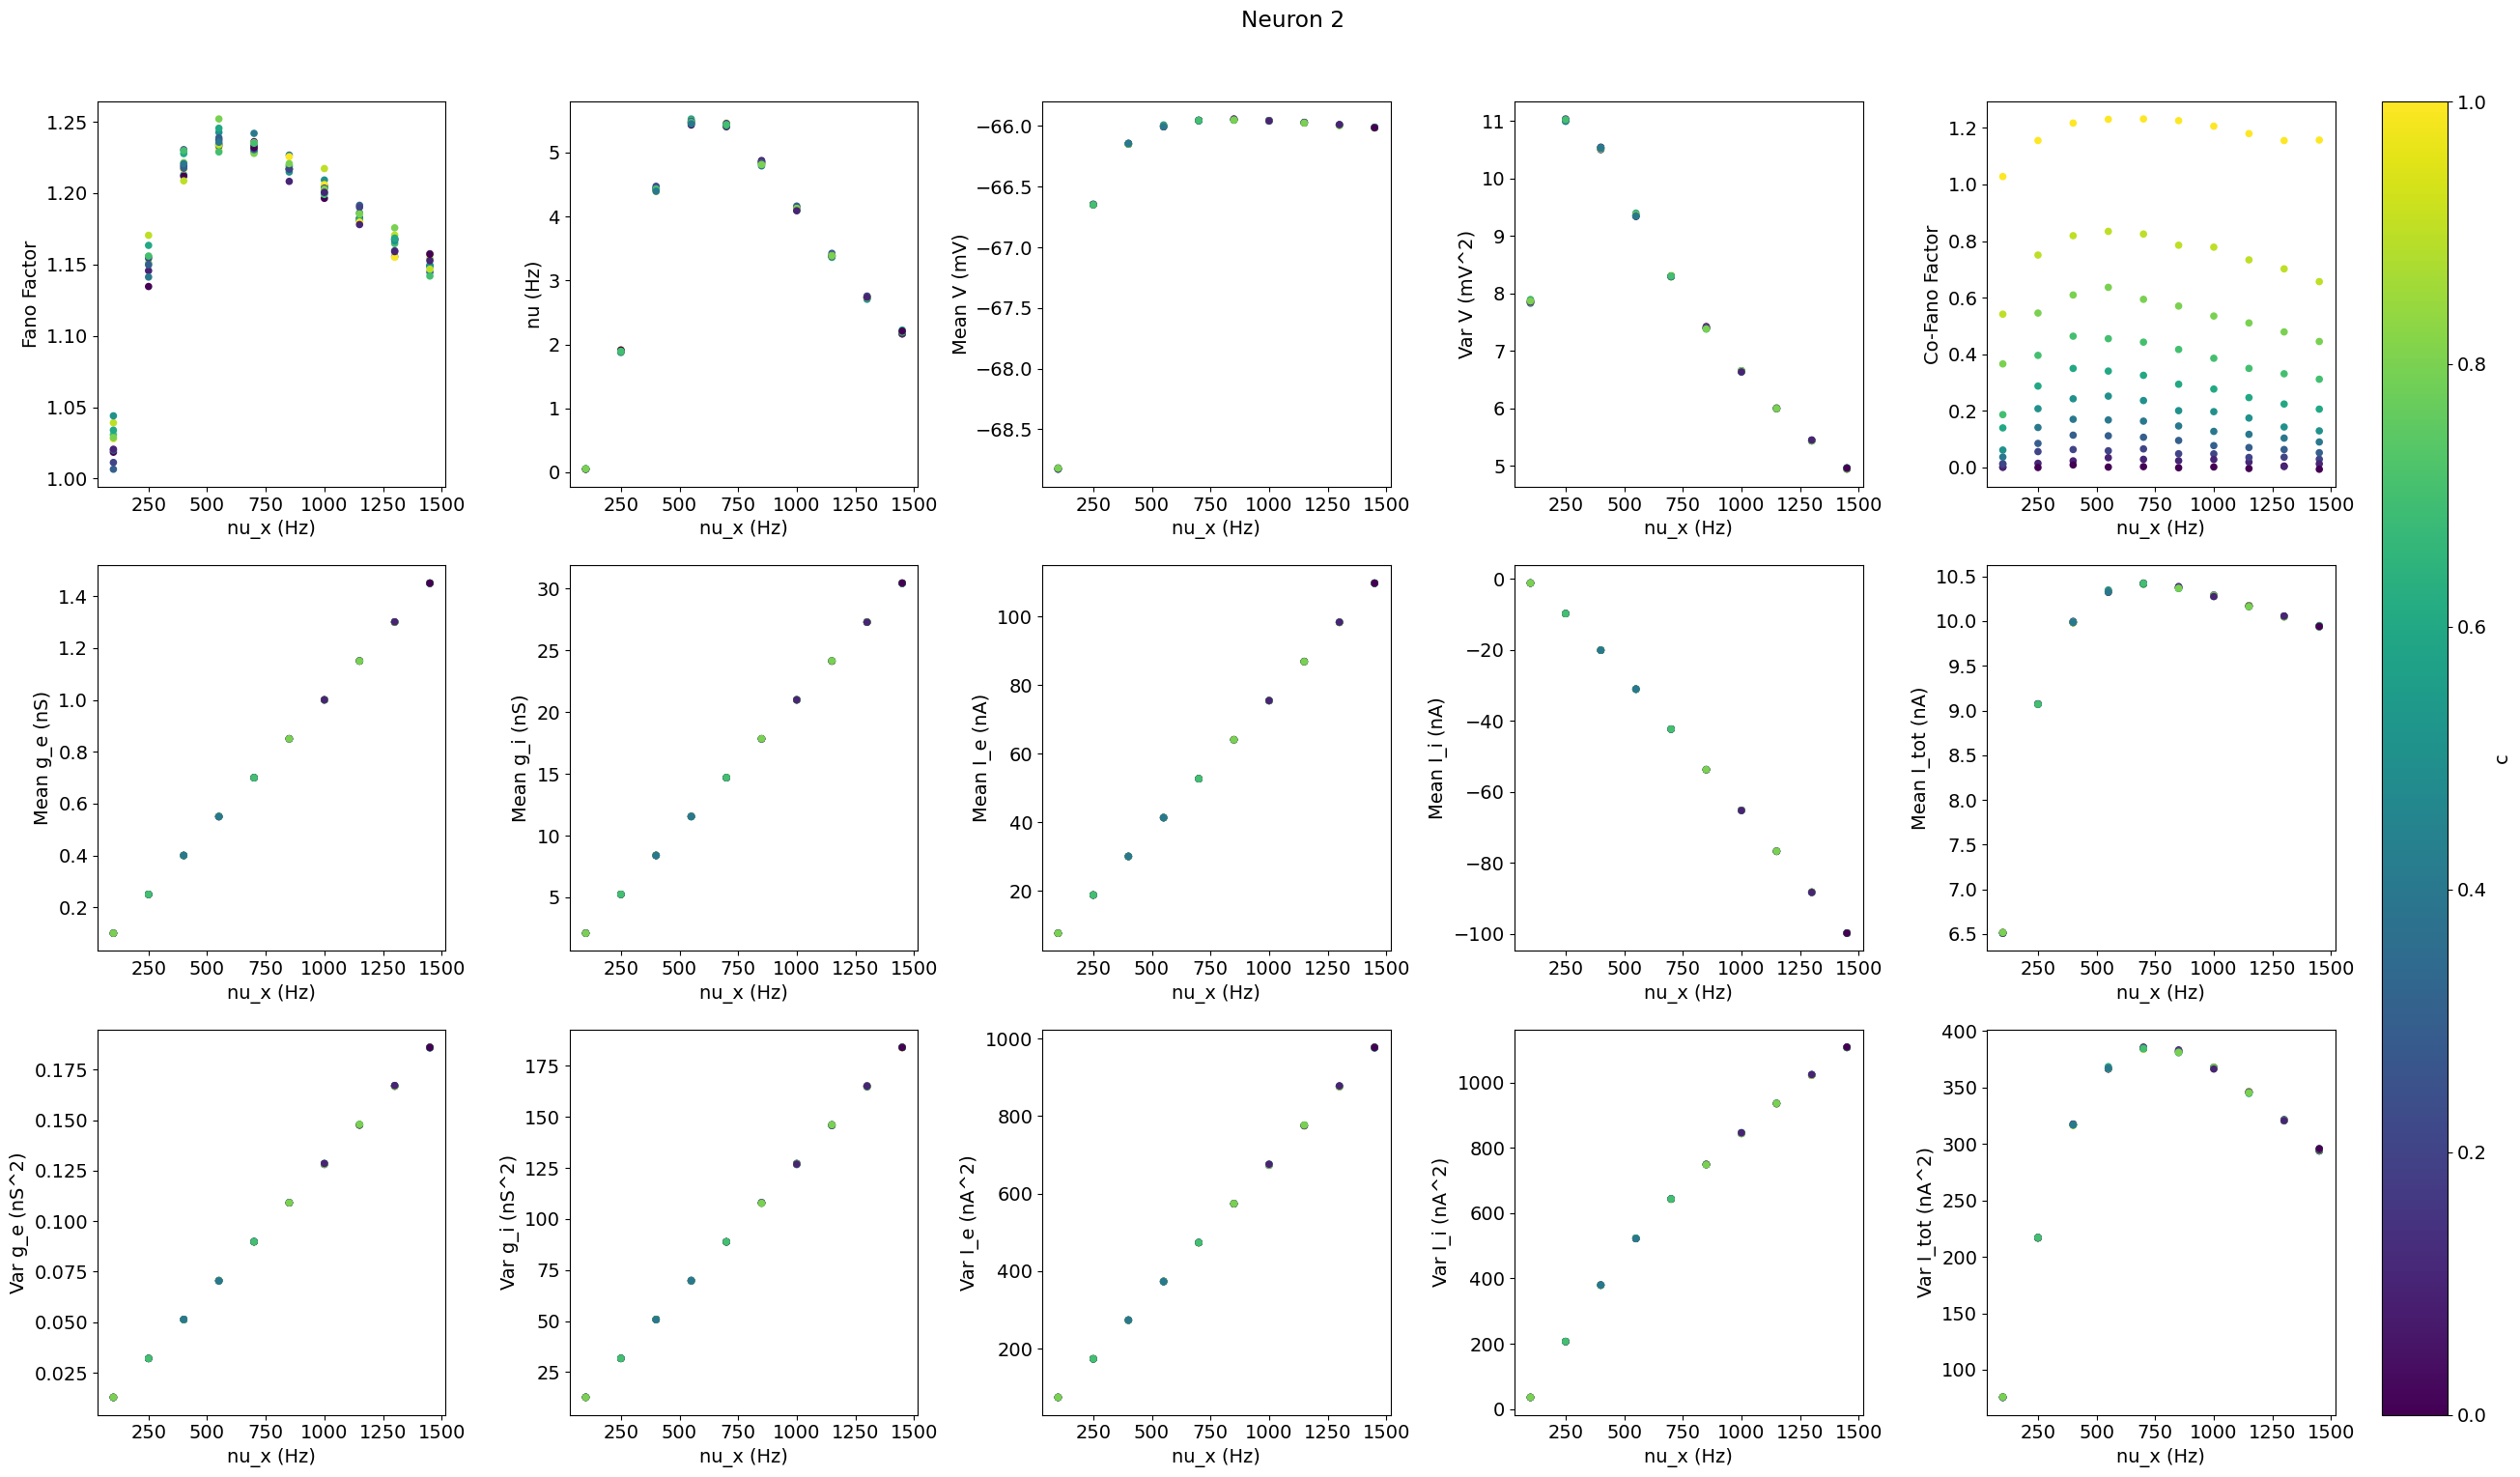

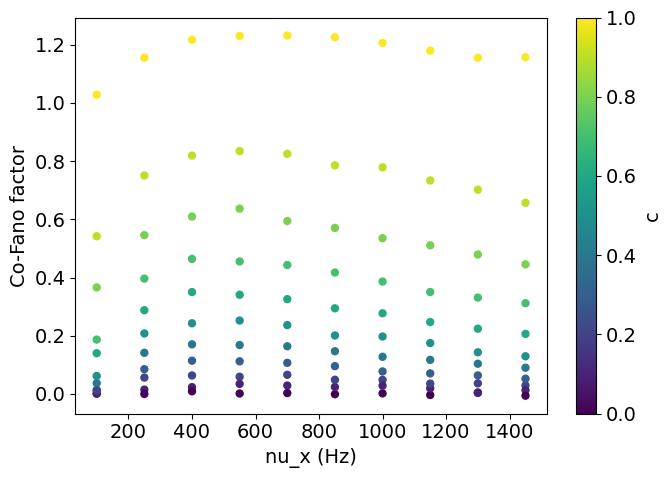

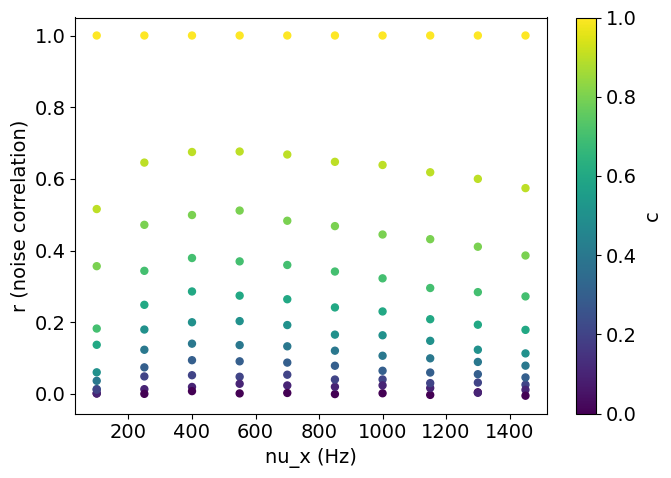

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

trials = collect_data("../../outputs/conductance/double_lif/nu_x_c/20251016-011349-P6DLbbnK")
plt.rcParams.update({'font.size': 14})

keys = [
    "fano_factor","nu","mean_V","var_V",
    "mean_g_e","mean_g_i","mean_I_e","mean_I_i","mean_I_tot",
    "var_g_e","var_g_i","var_I_e","var_I_i","var_I_tot",
]

N_CELLS = 2

dfs = []
for i in range(N_CELLS):
    rows = []
    for params, results in trials:
        row = {"nu_x": float(params["nu_x"]), "c": float(params["c"])}
        for k in keys:
            v = results[k]
            if np.isscalar(v) or (isinstance(v, np.ndarray) and v.ndim == 0):
                row[k] = float(v)
            elif isinstance(v, np.ndarray) and v.ndim == 1 and v.size == N_CELLS:
                row[k] = float(v[i])
        rows.append(row)
    dfs.append(pd.DataFrame(rows))

df_co = pd.DataFrame(
    {"nu_x": [float(p["nu_x"]) for p, _ in trials],
     "c":    [float(p["c"])    for p, _ in trials],
     "co_fano_factor": [float(np.ravel(r["co_fano_factor"])[0]) for _, r in trials]}
)



def plot_summary(df, neuron_idx, outname):
    fig, axs = plt.subplots(3, 5, figsize=(27, 15))
    fig.suptitle(f"Neuron {neuron_idx+1}", y=1.02)
    opts = dict(c=df["c"], cmap="viridis", vmin=0, vmax=1, s=20)

    axs[0,0].scatter(df["nu_x"], df["fano_factor"], **opts); axs[0,0].set_xlabel("nu_x (Hz)"); axs[0,0].set_ylabel("Fano Factor")
    axs[0,1].scatter(df["nu_x"], df["nu"],          **opts); axs[0,1].set_xlabel("nu_x (Hz)"); axs[0,1].set_ylabel("nu (Hz)")
    axs[0,2].scatter(df["nu_x"], df["mean_V"],      **opts); axs[0,2].set_xlabel("nu_x (Hz)"); axs[0,2].set_ylabel("Mean V (mV)")
    axs[0,3].scatter(df["nu_x"], df["var_V"],       **opts); axs[0,3].set_xlabel("nu_x (Hz)"); axs[0,3].set_ylabel("Var V (mV^2)")
    axs[0,4].scatter(df["nu_x"], df_co["co_fano_factor"], **opts); axs[0,4].set_xlabel("nu_x (Hz)"); axs[0,4].set_ylabel("Co-Fano Factor")

    axs[1,0].scatter(df["nu_x"], df["mean_g_e"],    **opts); axs[1,0].set_xlabel("nu_x (Hz)"); axs[1,0].set_ylabel("Mean g_e (nS)")
    axs[1,1].scatter(df["nu_x"], df["mean_g_i"],    **opts); axs[1,1].set_xlabel("nu_x (Hz)"); axs[1,1].set_ylabel("Mean g_i (nS)")
    axs[1,2].scatter(df["nu_x"], df["mean_I_e"],    **opts); axs[1,2].set_xlabel("nu_x (Hz)"); axs[1,2].set_ylabel("Mean I_e (nA)")
    axs[1,3].scatter(df["nu_x"], df["mean_I_i"],    **opts); axs[1,3].set_xlabel("nu_x (Hz)"); axs[1,3].set_ylabel("Mean I_i (nA)")
    axs[1,4].scatter(df["nu_x"], df["mean_I_tot"],  **opts); axs[1,4].set_xlabel("nu_x (Hz)"); axs[1,4].set_ylabel("Mean I_tot (nA)")

    axs[2,0].scatter(df["nu_x"], df["var_g_e"],     **opts); axs[2,0].set_xlabel("nu_x (Hz)"); axs[2,0].set_ylabel("Var g_e (nS^2)")
    axs[2,1].scatter(df["nu_x"], df["var_g_i"],     **opts); axs[2,1].set_xlabel("nu_x (Hz)"); axs[2,1].set_ylabel("Var g_i (nS^2)")
    axs[2,2].scatter(df["nu_x"], df["var_I_e"],     **opts); axs[2,2].set_xlabel("nu_x (Hz)"); axs[2,2].set_ylabel("Var I_e (nA^2)")
    axs[2,3].scatter(df["nu_x"], df["var_I_i"],     **opts); axs[2,3].set_xlabel("nu_x (Hz)"); axs[2,3].set_ylabel("Var I_i (nA^2)")
    axs[2,4].scatter(df["nu_x"], df["var_I_tot"],   **opts); axs[2,4].set_xlabel("nu_x (Hz)"); axs[2,4].set_ylabel("Var I_tot (nA^2)")

    sm = plt.cm.ScalarMappable(cmap="viridis"); sm.set_clim(0,1)
    plt.tight_layout(rect=[0, 0, 0.96, 1])  # leave right margin
    fig.colorbar(sm, ax=axs.ravel().tolist(), location="right",
                fraction=0.03, pad=0.02, label="c")
    plt.savefig(outname, dpi=300, bbox_inches="tight"); plt.show()

for i, df in enumerate(dfs):
    plot_summary(df, i, f"detailed_summary_neuron{i+1}_by_c.png")

plt.figure(figsize=(7,5))
sc = plt.scatter(df_co["nu_x"], df_co["co_fano_factor"], c=df_co["c"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Co-Fano factor")
plt.colorbar(sc, label="c")
plt.tight_layout(); plt.savefig("co_fano_vs_nu_x_by_c.png", dpi=300, bbox_inches="tight"); plt.show()

# define r = co_fano_factor / sqrt(fano_factor1 * fano_factor2
# now plot this against nu_x for various c

plt.figure(figsize=(7,5))
df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])
sc = plt.scatter(df_co["nu_x"], df_co["r"], c=df_co["c"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("r (noise correlation)")
plt.colorbar(sc, label="c")
plt.tight_layout(); plt.savefig("r_vs_nu_x_by_c.png", dpi=300, bbox_inches="tight"); plt.show()


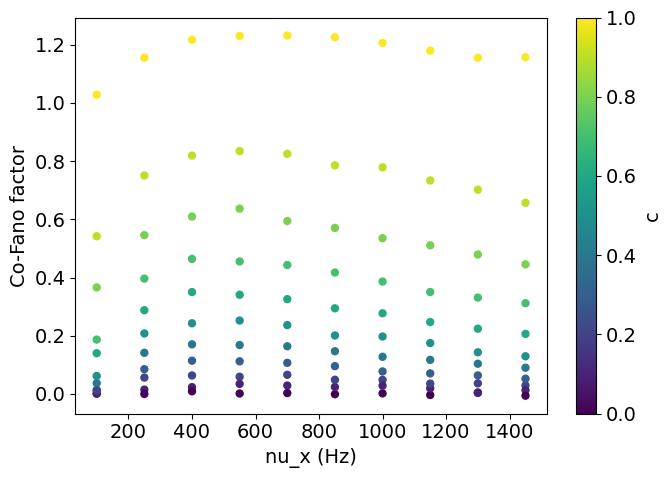

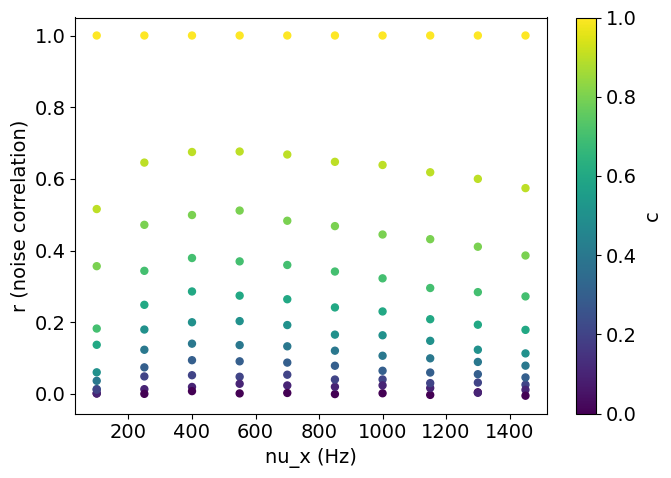

In [43]:
plt.figure(figsize=(7,5))
sc = plt.scatter(df_co["nu_x"], df_co["co_fano_factor"], c=df_co["c"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Co-Fano factor")
plt.colorbar(sc, label="c")
plt.tight_layout(); plt.savefig("co_fano_vs_nu_x_by_c.png", dpi=300, bbox_inches="tight"); plt.show()

# define r = co_fano_factor / sqrt(fano_factor1 * fano_factor2
# now plot this against nu_x for various c

plt.figure(figsize=(7,5))
df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])
sc = plt.scatter(df_co["nu_x"], df_co["r"], c=df_co["c"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("r (noise correlation)")
plt.colorbar(sc, label="c")
plt.tight_layout(); plt.savefig("r_vs_nu_x_by_c.png", dpi=300, bbox_inches="tight"); plt.show()